In [1]:
%matplotlib inline

import os
from dbfread import DBF
import pandas as pd 
import shapefile as shp
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import pysal as ps
from pylab import *

import rasterio 
from rasterio.warp import calculate_default_transform, reproject, Resampling
import gdal


C:\Users\fuad.alzaben\Miniconda3\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\fuad.alzaben\Miniconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# Import Sample EID-AUH Data

In [2]:
EID_AUH_path = "C:/Users/fuad.alzaben/OneDrive - Accenture/Etisalat 2020/AI ML Workstream/Use case - Satellite Image Recognition/Etisalat_Sample_Data/EID-AUH.xlsb"
EA_df = pd.read_excel(EID_AUH_path, engine='pyxlsb')

In [3]:
print('Number of records: '+str(EA_df.shape[0]))
print('Number of columns: '+str(EA_df.shape[1]))

Number of records: 38582
Number of columns: 12


 **Transform Excel dataframe to GeoDataFrame**

In [4]:
gdf = gpd.GeoDataFrame(EA_df, geometry=gpd.points_from_xy(EA_df.EID_X, EA_df.EID_Y))
display(gdf.head())

,REGION_CODE,REGION_SUB_CODE,OLT_CODE,FDH_NUMBER,FDH_TYPE,FDH_STATUS,MASTER_EID,EID_NUMBER,EID_STATUS,COMMUNITY,EID_X,EID_Y,geometry
0,AUH,AUH,OKA,214,I,ORDINARY,AU005934000,AU005934000,Home Ready,Abu Dhabi - KHALIFA CITY A,54.577834,24.415503,POINT (54.57783 24.41550)
1,AUH,AUH,OKA,222,I,ORDINARY,AU005945000,AU005945000,Home Ready,Abu Dhabi - KHALIFA CITY A,54.597810,24.416168,POINT (54.59781 24.41617)
2,AUH,AUH,OKA,228,I,ORDINARY,AU005952000,AU005952000,Home Ready,Abu Dhabi - KHALIFA CITY A,54.579460,24.403858,POINT (54.57946 24.40386)
3,AUH,AUH,OKA,235,I,ORDINARY,AU005976000,AU005976000,Home Ready,Abu Dhabi - KHALIFA CITY A,54.575239,24.415490,POINT (54.57524 24.41549)
4,AUH,AUH,OKA,245,I,ORDINARY,AU005993000,AU005993000,Home Ready,Abu Dhabi - KHALIFA CITY A,54.604584,24.423392,POINT (54.60458 24.42339)


# Import .SHP file using Geopandas

In [5]:
shp_path = "C:/Users/fuad.alzaben/OneDrive - Accenture/Etisalat 2020/AI ML Workstream/Use case - Satellite Image Recognition/Etisalat_Sample_Data/plot_parcels_sample/Plot_parcels-sample.shp"
source_shp = gpd.read_file(shp_path)

In [6]:
display(source_shp.head())

,PLOTID,STATUS,Date,geometry
0,448594,Constructed,2019-10-07,"POLYGON ((54.60271 24.43226, 54.60289 24.43173..."
1,4175682,Not Constructed,2019-10-07,"POLYGON ((54.69584 24.32496, 54.69555 24.32516..."
2,451523,Not Constructed,2019-10-07,"POLYGON ((54.77151 24.35255, 54.77175 24.35224..."
3,4185516,Not Constructed,2019-10-07,"POLYGON ((54.72537 24.28692, 54.72507 24.28694..."
4,436103,Not Constructed,2019-10-07,"POLYGON ((54.78591 24.33098, 54.78591 24.33100..."


**Check the coordintate reference system used in both dataframes**

In [7]:
print('SHP file crs type: '+str(source_shp.crs))

# Set the crs of the excel file to epsg:4326 to match the crs of .shp file 
gdf.crs = {'init': 'epsg:4326'}
print('Excel file crs type: '+str(gdf.crs))

SHP file crs type: {'init': 'epsg:4326'}
Excel file crs type: {'init': 'epsg:4326'}


In [8]:
print(type(source_shp.geometry[0]))
print(type(gdf.geometry[0]))
print(gdf.sindex)
print(source_shp.sindex)

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.point.Point'>
rtree.index.Index(bounds=[54.4898646, 24.27949333, 54.7977422, 24.49737029], size=38582)
rtree.index.Index(bounds=[54.490810134000014, 24.251660060000006, 54.80379141899999, 24.513819924000018], size=35301)


In [9]:
# Join both geodataframes using inner join first gdf mentioned is retains most of its data while the second one doesn't
#Joined_df = gpd.sjoin(gdf, source_shp, how='inner', op='within')
Joined_df = gpd.sjoin(source_shp, gdf, how='inner', op='contains')

# Display a random sample of the 
Joined_df.sample(5)

,PLOTID,STATUS,Date,geometry,index_right,REGION_CODE,REGION_SUB_CODE,OLT_CODE,FDH_NUMBER,FDH_TYPE,FDH_STATUS,MASTER_EID,EID_NUMBER,EID_STATUS,COMMUNITY,EID_X,EID_Y
25125,4178362,Not Constructed,2019-10-07,"POLYGON ((54.68397 24.30617, 54.68372 24.30635...",30985,AUH,AUH,OSK,57,O,ORDINARY,AU011683000,AU011683010,Planned,Abu Dhabi - AL WATHBA NORTH,54.683955,24.306390
27088,4225973,Not Constructed,2019-10-07,"POLYGON ((54.57636 24.43301, 54.57672 24.43193...",7466,AUH,AUH,OKA,42,O,ORDINARY,AU003687000,AU003687162,Planned,Abu Dhabi - KHALIFA CITY A,54.576191,24.432173
6668,4186700,Not Constructed,2019-10-07,"POLYGON ((54.69865 24.28708, 54.69867 24.28735...",32801,AUH,AUH,OSK,98,O,ORDINARY,AU011737000,AU011737354,Planned,Abu Dhabi - AL WATHBA NORTH,54.698829,24.287208
33104,419432,Not Constructed,2019-10-07,"POLYGON ((54.75136 24.37191, 54.75161 24.37196...",23529,AUH,AUH,OSK,179,O,PATCHFREE,AU013591000,AU013591095,Planned,Abu Dhabi - SHAMKHA SOUTH,54.751524,24.371752
35251,463757,Constructed,2019-10-07,"POLYGON ((54.75366 24.35382, 54.75365 24.35386...",28492,AUH,AUH,OSK,216,O,PATCHFREE,AU013774000,AU013774065,Home Ready,Abu Dhabi - SHAMKHA SOUTH,54.753813,24.353777


In [10]:
Joined_df.crs

{'init': 'epsg:4326'}

In [11]:
Joined_df.shape

(37452, 17)

In [15]:
print('Number of EID-AUH excel records: '+str(gdf.shape[0]))
print('Number of plot_parcel-sample.shp file records: '+str(source_shp.shape[0]))
Diff = gdf.shape[0]-Joined_df.shape[0]
print('Unmapped records: '+str(Diff))

Number of EID-AUH excel records: 38582
Number of plot_parcel-sample.shp file records: 35301
Unmapped records: 1130


In [16]:
# Save output to excel
#Joined_df.to_csv("Joined_Data.csv")

-------------------------------------------------------------------------------------------------------------------------------

**Data Analysis of Joined_df**

In [17]:
Joined_df.STATUS.value_counts()

Not Constructed       23987
Constructed           11691
Under Construction     1632
Undefined               142
Name: STATUS, dtype: int64

In [18]:
Joined_df.Date.value_counts()

2019-10-07    37452
Name: Date, dtype: int64

In [19]:
Joined_df.COMMUNITY.value_counts()

Abu Dhabi - SHAMKHA SOUTH      13255
Abu Dhabi - AL WATHBA NORTH    11759
Abu Dhabi - KHALIFA CITY A      7928
Abu Dhabi - AL RAYYANA          1889
Abu Dhabi - AL RAHA GARDENS     1759
Abu Dhabi - AL RAHA BEACH        534
Abu Dhabi - MASDAR CITY          291
Abu Dhabi - RAWDAT AL REEF        28
Abu Dhabi - ZAYED CITY             6
Abu Dhabi - YAS ISLAND             2
Abu Dhabi - BANIYAS EAST           1
Name: COMMUNITY, dtype: int64

In [20]:
Joined_df.EID_STATUS.value_counts()

Planned           26617
Home Ready         9439
Under Planning     1056
Home Pass           340
Name: EID_STATUS, dtype: int64

In [21]:
Joined_df.EID_NUMBER.value_counts()[Joined_df.EID_NUMBER.value_counts()>=2]

AU013709035    2
AU013989056    2
AU003978255    2
AU014352000    2
AU013804107    2
              ..
AU014344000    2
AU003978231    2
AU011700044    2
AU013650066    2
AU013532066    2
Name: EID_NUMBER, Length: 210, dtype: int64

In [22]:
print('Excel unique IDs: '+str(gdf.EID_NUMBER.nunique()))
print('Joined_df unique IDs: '+str(Joined_df.EID_NUMBER.nunique()))

# Which means that more than one EID lie in the same polygon

Excel unique IDs: 38582
Joined_df unique IDs: 37242


In [23]:
display(Joined_df[Joined_df['EID_NUMBER']=='AU013579024'])
Joined_df[Joined_df['EID_NUMBER']=='AU013579024']['STATUS']


,PLOTID,STATUS,Date,geometry,index_right,REGION_CODE,REGION_SUB_CODE,OLT_CODE,FDH_NUMBER,FDH_TYPE,FDH_STATUS,MASTER_EID,EID_NUMBER,EID_STATUS,COMMUNITY,EID_X,EID_Y
25441,4216659,Constructed,2019-10-07,"POLYGON ((54.74202 24.35076, 54.74193 24.35070...",38280,AUH,AUH,OSK,203,O,PATCHFREE,AU013579000,AU013579024,Under Planning,Abu Dhabi - SHAMKHA SOUTH,54.741933,24.350775
34650,4269389,Not Constructed,2019-10-07,"POLYGON ((54.74215 24.35056, 54.74206 24.35050...",38280,AUH,AUH,OSK,203,O,PATCHFREE,AU013579000,AU013579024,Under Planning,Abu Dhabi - SHAMKHA SOUTH,54.741933,24.350775


25441        Constructed
34650    Not Constructed
Name: STATUS, dtype: object

-------------------------------------------------------------------------------------------------------------------------------

**Plot the individual polygons in the shp file**

Owner EID number: AU000649148
Plot ID: 4241969
Community name: Abu Dhabi - AL RAHA GARDENS
Construction status: Constructed
Fixed line connection status: Home Ready
Plot polygon shape: 



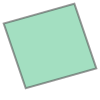

In [24]:
# Select the index number of the polygon to plot
n = 89

# Display details
print('Owner EID number: '+Joined_df.loc[n, 'EID_NUMBER'])
print('Plot ID: '+Joined_df.loc[n, 'PLOTID'])
print('Community name: '+Joined_df.loc[n, 'COMMUNITY'])
print('Construction status: '+Joined_df.loc[n, 'STATUS'])
print('Fixed line connection status: '+Joined_df.loc[n, 'EID_STATUS'])
print('Plot polygon shape: \n')
Joined_df.loc[n, 'geometry'] 

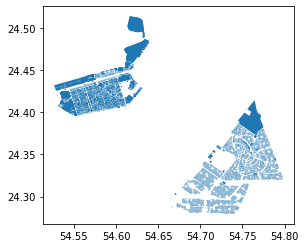

In [25]:
Joined_df.plot()

**Plot all polygons in the geodataframe (Full Map)**

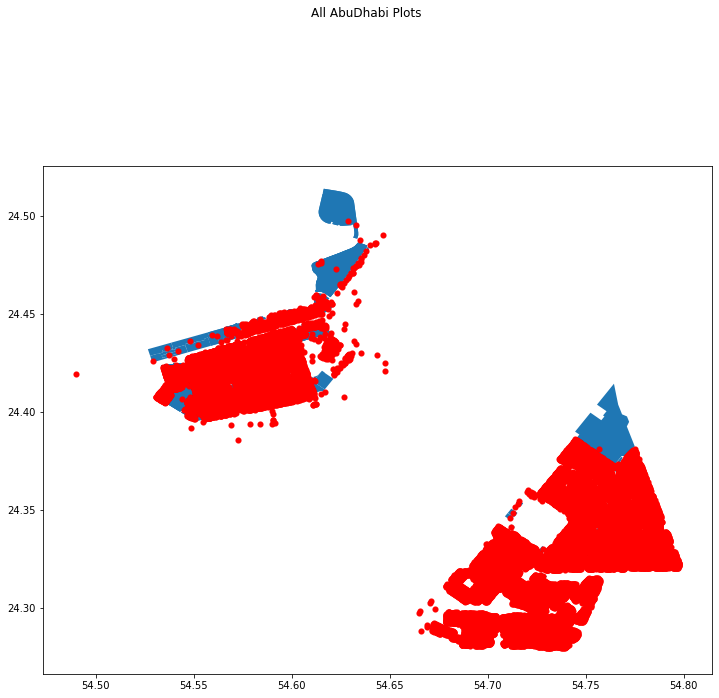

In [24]:
f, ax = plt.subplots(1, figsize=(12, 12))
f.suptitle('All AbuDhabi Plots')
ax = Joined_df.plot(ax=ax)
ax = gdf.plot(ax=ax, color='red', linewidth=0.1)
plt.show()

Zoom in map using this function

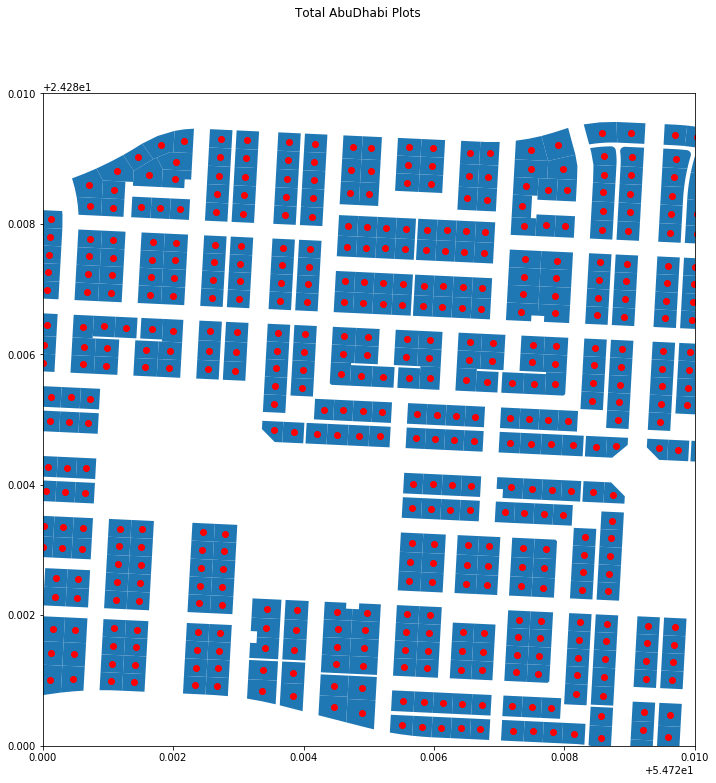

In [25]:
#Zoomed in map
f, ax = plt.subplots(1, figsize=(12, 12))
f.suptitle('Total AbuDhabi Plots')
ax = Joined_df.plot(ax=ax)
ax = gdf.plot(ax=ax, color='red')
ax.set_xlim(54.72, 54.73)
ax.set_ylim(24.28, 24.29)
plt.show()

Filter plots based on Joined_df status

In [26]:
# Get status unique values
status = Joined_df.STATUS.unique()

# Filter constructed plots
filter_constructed = Joined_df[Joined_df['STATUS'] == status[0]]

# Filter unconstructed plots
filter_unconstructed = Joined_df[Joined_df['STATUS'] == status[1]]

# Filter undefined plots
filter_undefined = Joined_df[Joined_df['STATUS'] == status[2]]

# Filter under construction plots
filter_underconstruction = Joined_df[Joined_df['STATUS'] == status[3]]

Filter plots based on joined_df EID_status

In [27]:
# Get EID_status unique values
EID_status = Joined_df.EID_STATUS.unique()

# Home ready plots
filter_homeready = gdf[gdf['EID_STATUS'] == EID_status[0]]

# Home pass plots
filter_homepass = gdf[gdf['EID_STATUS'] == EID_status[1]]

# planned plots
filter_planned = gdf[gdf['EID_STATUS'] == EID_status[2]]

# under planning plots
filter_underplanning = gdf[gdf['EID_STATUS'] == EID_status[3]]

Filter plots based on neighborhood

In [28]:
# Get EID_status unique values
Neighborhood = Joined_df.COMMUNITY.unique()

# Neighborhoods
Neighborhood1 = Joined_df[Joined_df['COMMUNITY'] == Neighborhood[0]]
Neighborhood2 = Joined_df[Joined_df['COMMUNITY'] == Neighborhood[1]]
Neighborhood3 = Joined_df[Joined_df['COMMUNITY'] == Neighborhood[2]]
Neighborhood4 = Joined_df[Joined_df['COMMUNITY'] == Neighborhood[3]]
Neighborhood5 = Joined_df[Joined_df['COMMUNITY'] == Neighborhood[4]]
Neighborhood6 = Joined_df[Joined_df['COMMUNITY'] == Neighborhood[5]]
Neighborhood7 = Joined_df[Joined_df['COMMUNITY'] == Neighborhood[6]]
Neighborhood8 = Joined_df[Joined_df['COMMUNITY'] == Neighborhood[7]]
Neighborhood9 = Joined_df[Joined_df['COMMUNITY'] == Neighborhood[8]]
Neighborhood10 = Joined_df[Joined_df['COMMUNITY'] == Neighborhood[9]]
Neighborhood11 = Joined_df[Joined_df['COMMUNITY'] == Neighborhood[10]]

Display map with filtered constructed and unconstructed plots

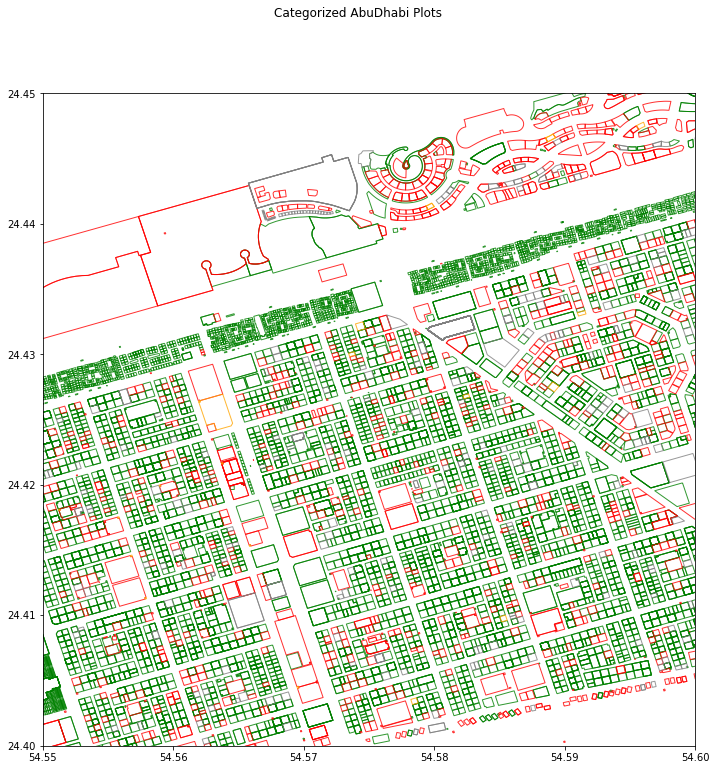

In [29]:
# Plot the polygons on the map
f, ax = plt.subplots(1, figsize=(12, 12))

# Set the map title
f.suptitle('Categorized AbuDhabi Plots')

# Select display type
display_status = True
display_EIDstatus = False
display_neighborhoods = False

# Enable/Disable zoom
zoom = True

# Set marker size
marker_size = 20

if display_status==True:
    # Set the components of the map (STATUS)
    ax = filter_constructed.plot(ax=ax, edgecolor='green', color='none', alpha=0.8, legend=True)
    ax = filter_unconstructed.plot(ax=ax, edgecolor='red', color='none', alpha=0.8, legend=True)
    ax = filter_undefined.plot(ax=ax, edgecolor='grey', color='none', alpha=0.8, legend=True)
    ax = filter_underconstruction.plot(ax=ax, edgecolor='orange', color='none', alpha=0.8, legend=True)

if display_EIDstatus==True:
    # Set the components of the map (EID_STATUS)
    ax = filter_homeready.plot(ax=ax, marker='*', edgecolor='none', color='green', alpha=1, legend=True, markersize=marker_size)
    ax = filter_homepass.plot(ax=ax, marker='*', edgecolor='none', color='grey', alpha=0.8, legend=True, markersize=marker_size)
    ax = filter_planned.plot(ax=ax, marker='*', edgecolor='none', color='blue', alpha=1, legend=True, markersize=marker_size)
    ax = filter_underplanning.plot(ax=ax, marker='*', edgecolor='none', color='orange', alpha=1, legend=True, markersize=marker_size)

if display_neighborhoods==True:
    # Set the neighborhods on the map
    ax = Neighborhood1.plot(ax=ax, edgecolor='none', color='blue', alpha=0.2, legend=True)
    ax = Neighborhood2.plot(ax=ax, edgecolor='none', color='yellow', alpha=0.2, legend=True)
    ax = Neighborhood3.plot(ax=ax, edgecolor='none', color='black', alpha=0.2, legend=True)
    ax = Neighborhood4.plot(ax=ax, edgecolor='none', color='grey', alpha=0.2, legend=True)
    ax = Neighborhood5.plot(ax=ax, edgecolor='none', color='red', alpha=0.2, legend=True)
    ax = Neighborhood6.plot(ax=ax, edgecolor='none', color='orange', alpha=0.2, legend=True)
    ax = Neighborhood7.plot(ax=ax, edgecolor='none', color='pink', alpha=0.2, legend=True)
    ax = Neighborhood8.plot(ax=ax, edgecolor='none', color='purple', alpha=0.2, legend=True)
    ax = Neighborhood9.plot(ax=ax, edgecolor='none', color='green', alpha=0.2, legend=True)
    ax = Neighborhood10.plot(ax=ax, edgecolor='none', color='green', alpha=0.4, legend=True)
    ax = Neighborhood11.plot(ax=ax, edgecolor='none', color='grey', alpha=0.5, legend=True)
    
# Set zoonm levels
if zoom==True:
    # Zoom In
    ax.set_xlim(54.55, 54.6)
    ax.set_ylim(24.4, 24.45)
else:
    # Zoom Out
    ax.set_xlim(54.40, 54.90)
    ax.set_ylim(24.25, 24.65)

# Show plots
plt.show()

# Import Raster Satellite Image (In Process)

In [33]:
# Install gdal package using conda install -c conda-forge gdal=2.4.4
# Reading in data
image_path = r'C:/Users/fuad.alzaben/OneDrive - Accenture\Etisalat 2020/AI ML Workstream/Use case - Satellite Image Recognition/Vendor_sample_images/Kompsat3A_SampleImagery/Kompsat3A_SampleImagery/Kompsat3A_SampleDataOnly/Kompsat3A_SampleDataOnly.tif'
satellite_image = rasterio.open(image_path, BigTIFF=True)

In [34]:
print('Raster type: '+str(type(satellite_image)))
print('Coordinate Reference System Used: '+str(satellite_image.crs))
print('Number of bands(spectrums): '+str(satellite_image.count))
print('Satellite Image Metadata: '+str(satellite_image.meta))

Raster type: <class 'rasterio.io.DatasetReader'>
Coordinate Reference System Used: EPSG:32640
Number of bands(spectrums): 4
Satellite Image Metadata: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 39560, 'height': 39360, 'count': 4, 'crs': CRS.from_epsg(32640), 'transform': Affine(0.3900098586781854, 0.0, 249253.289094795,
       0.0, -0.3900099083122502, 2719208.81665446)}


Change crs to match our data

In [35]:
# Read different bands(spectrums) from the image
blue = satellite_image.read(1)
green = satellite_image.read(2)
red = satellite_image.read(3)
band4 = satellite_image.read(4)

# Stack the spectrums into one numpy array (Ex: [R1, G1, B1])
pix = np.dstack((blue, green, red, band4))

# Set the boundaries of the image
bounds = (satellite_image.bounds.left, satellite_image.bounds.right, \
          satellite_image.bounds.bottom, satellite_image.bounds.top)

MemoryError: Unable to allocate 11.6 GiB for an array with shape (39360, 39560, 4) and data type uint16

In [ ]:
# Plot the satellite image separately
#plt.imshow(pix, cmap='hot')
plt.imshow(blue)
plt.show()

In [ ]:
# Plotting as a base for our polygons
f = plt.figure(figsize=(6, 6))
ax = plt.imshow(pix, extent=bounds)

In [49]:
def reproject_et(inpath, outpath, new_crs):
    dst_crs = new_crs # CRS for web meractor 

    with rasterio.open(inpath, 'r') as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(outpath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [70]:
# Set reprojected satellite image
r_image_path = r'C:/Users/fuad.alzaben/OneDrive - Accenture\Etisalat 2020/AI ML Workstream/Use case - Satellite Image Recognition/Vendor_sample_images/Kompsat3A_SampleImagery/Kompsat3A_SampleImagery/Kompsat3A_SampleDataOnly/r_Kompsat3A_SampleDataOnly.tif'
reproject_et(inpath=image_path, outpath=r_image_path, new_crs='+proj=longlat +datum=WGS84 +no_defs')

CRSError: Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.

In [78]:
dst_crs = '+proj=longlat +datum=WGS84 +no_defs '# CRS for web meractor 

with rasterio.open(image_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(r_image_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

CRSError: Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.